In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import random

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

## to throw:

In [3]:
class MyModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.linear1 = nn.Linear(4, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)
        
        self.param_lienar1 = nn.Linear(160, 128)
        self.param_lienar2 = nn.Linear(160, 128)
        
        
    def forward(self, obs, param_vec):
        
        x1 = self.linear1(obs) * self.param_lienar1(param_vec)
        x1 = F.tanh(x1)
        
        x2 = self.linear2(x1) * self.param_lienar2(param_vec)
        # x2 = F.tanh(x2)
        
        x3 = self.linear3(x2)
        
        return x3

In [4]:
batch_size = 256

model = MyModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

losses = []

In [5]:

for i in tqdm(range(1000000)):

    obs = torch.normal(0, 1, size=(batch_size, 4))

    param_w1 = torch.normal(0, 3, size=(batch_size, 4, 32)) * np.sqrt(1/32)
    param_w2 = torch.normal(0, 3, size=(batch_size, 32, 1)) * np.sqrt(1/16)


    # Target:
    x = torch.unsqueeze(obs, -2) # [batch, (pairs), 1, features_in]
    x = torch.matmul(x.cpu(), param_w1) # [batch, (pairs), 1, features_out]
    x = torch.tanh(x)
    r = torch.matmul(x, param_w2) # [batch, (pairs), 1, 1]
    r = r.squeeze(-1).squeeze(-1) # [batch, (pairs)]
    # r = torch.clip(r, -1, 1)
    target = r
    
    param_vec = torch.concat((
            param_w1.reshape(batch_size, -1), 
            param_w2.reshape(batch_size, -1)
        ), 
        dim=-1
    )
    
    y = model(obs, param_vec).squeeze(-1)
    
    
    loss = criterion(y, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # break
    if i % 20 == 0:
        losses.append(loss.item())
        clear_output(True)
        plt.plot(losses)
        # plt.ylim([0, 0.5])
        plt.show()

  0%|          | 1100/1000000 [00:07<1:49:30, 152.02it/s]


KeyboardInterrupt: 

(array([ 2.,  6., 12., 34., 93., 66., 29.,  9.,  3.,  2.]),
 array([-2.9374876 , -2.33644342, -1.73539913, -1.13435495, -0.53331071,
         0.06773353,  0.66877776,  1.269822  ,  1.87086618,  2.47191048,
         3.07295465]),
 <BarContainer object of 10 artists>)

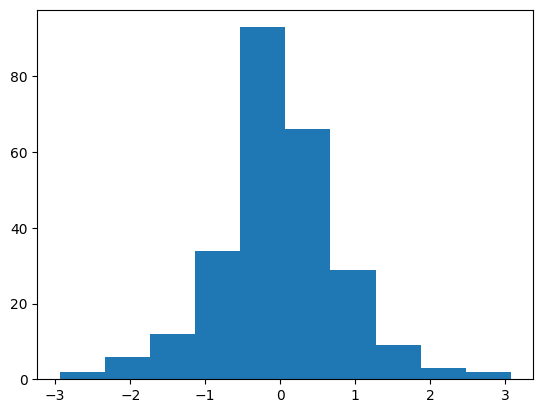

In [5]:
plt.hist(y.detach())

## Crazy:

In [2]:
z_dim = 16
obs_len = 2

In [3]:
class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class RewardModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(z_dim + obs_len, 64),
            SinActivation(),
            nn.Linear(64, 1),
            # SinActivation(),
            # nn.Linear(16, 1),
            # SinActivation(),
            # nn.Tanh(),
        )
        
    def forward(self, x):
        return self.mlp(x)
    
    
class RewardModel_(nn.Module):
    def __init__(self, ):
        super(RewardModel_, self).__init__()
        self.linear1 = nn.Linear(obs_len, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, 1)
        
        self.linear_z1 = nn.Linear(z_dim, 512)
        self.linear_z2 = nn.Linear(z_dim, 512)
        self.linear_z3 = nn.Linear(z_dim, 512)
        
        
    def forward(self, x):
        
        obs, z = x[..., :obs_len], x[..., obs_len:]
        # print(obs.shape, z.shape)
        
        x1 = self.linear1(obs) * self.linear_z1(z)
        x1 = F.mish(x1)
        x2 = self.linear2(x1) * self.linear_z2(z)
        x2 = F.mish(x2)
        x3 = self.linear3(x2) * self.linear_z3(z)
        x3 = F.mish(x3)
        x4 = self.linear4(x3)
        
        return x4
    
    
class RBFActivation(nn.Module):
    def __init__(self, num_features, gamma=1.0):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_features))  # Learnable centers
        self.gamma = gamma
    
    def forward(self, x):
        return torch.exp(-self.gamma * (x - self.centers) ** 2)

class MLPWithRBF(nn.Module):
    def __init__(self, gamma=1.0):
        super().__init__()
        self.fc1 = nn.Linear(obs_len + z_dim, 512)
        self.rbf = RBFActivation(512, gamma)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.rbf(x)
        x = self.fc2(x)
        return x

In [4]:
# s1, s2 = torch.linspace(-1, 1, 20), torch.linspace(-1, 1, 20)
# # s1, s2 = torch.rand((50,)) * 2 - 1, torch.rand((50,)) * 2 - 1
# grid_s1, grid_s2 = torch.meshgrid(s1, s2, indexing='ij')
# s = torch.stack([grid_s1.flatten(), grid_s2.flatten()], dim=-1)

In [40]:
model = MLPWithRBF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
dist_losses = []

In [41]:
rate = 1
exp_dist = torch.distributions.Exponential(rate)


def cross_correlation(r):
    r = r - r.mean(dim=1, keepdim=True)
    r = r / (r.std(dim=1, keepdim=True) + 1e-8)
    corr = torch.matmul(r, r.T) / r.shape[1]
    return corr

def disjoint_loss(v1, v2, alpha=10.0):
    diff = torch.abs(v1 - v2)  # Element-wise absolute difference
    loss = torch.sigmoid(-alpha * diff).mean()  # Apply sigmoid and average
    return loss

for i in tqdm(range(10000)):
    
    z = torch.normal(0, 1, size=(32, z_dim,))
    # z = torch.rand(32, z_dim) * 2 - 1

    for m in [1,]:
        s = torch.normal(0, 1, (100, obs_len))
        
        if m != 1:
            s = s - s.mean(dim=0) + torch.empty((1, obs_len)).uniform_(-0.5, 0.5)
            s = s * m
            
        x = torch.concat(
            (
                s.unsqueeze(0).repeat(32, 1, 1),
                z.unsqueeze(1).repeat(1, s.shape[0], 1)
            ),
            dim=-1
        )

        x = x.to(device)
        r = model(x).squeeze(-1)

        # Cross correlation:
        corr = cross_correlation(r)
        # print(r.min())
        
        # # Euclidian distance:
        # z_norm = (z**2).sum(dim=1, keepdim=True)
        # D_squared = z_norm + z_norm.T - 2 * (z @ z.T)
        # weight = torch.clamp(D_squared, min=0.0)
        
        # Cosine similarity:
        z_norm = z / (z.norm(dim=1, keepdim=True) + 1e-8)  # Normalize rows
        cosine_similarity = z_norm @ z_norm.T  # Compute cosine similarity
        weight = 1 - cosine_similarity

        corr = torch.clip(corr, 0.0, 1)
        
        weighted_corr = weight.to(device) * corr
        # weighted_corr = corr
        mask = torch.triu(torch.ones_like(corr, dtype=torch.bool), diagonal=1)
        corr_loss = weighted_corr[mask].mean()

        # Distirbution loss:
        target_dist = exp_dist.sample(r.shape).to(device)
        dist_loss = torch.norm(r.sort().values - target_dist.sort().values, dim=-1, p=2).mean()
        
        # Coverage loss:
        coverage_loss = (r.max(dim=0).values - 1)**2 + (r.min(dim=0).values + 1)**2
        coverage_loss = coverage_loss.mean()
        # coverage_loss = ((r.mean(dim=0) - 0.5)**2).mean()



        loss = corr_loss + 0.5*coverage_loss - torch.clip(r.std(-1), 0, 1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        dist_losses.append(coverage_loss.item())
    # break
    
    if i % 20 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        clear_output(True)
        axs[0].plot(losses)
        axs[1].imshow(corr.detach().cpu())
        axs[2].plot(dist_losses)
        # _ = axs[3].hist(r[0].detach().cpu(), bins=20, alpha=0.5)
        # _ = axs[3].hist(target_dist[0].detach().cpu(), bins=20, alpha=0.5)


        plt.show()

 99%|█████████▊| 9860/10000 [01:56<00:01, 84.78it/s]


KeyboardInterrupt: 

In [42]:
# r
# diff = torch.cdist(r, r, p=1)
# mask = torch.eye(r.shape[0], device=r.device).bool()
# diff = diff.masked_fill(mask, float('inf')) 

In [43]:
# s1, s2 = torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100)
# # s1, s2 = torch.rand((50,)) * 2 - 1, torch.rand((50,)) * 2 - 1
# grid_s1, grid_s2 = torch.meshgrid(s1, s2, indexing='ij')
# eval_s = torch.stack([grid_s1.flatten(), grid_s2.flatten()], dim=-1)

eval_s = torch.rand((10000, obs_len)) * 2 - 1

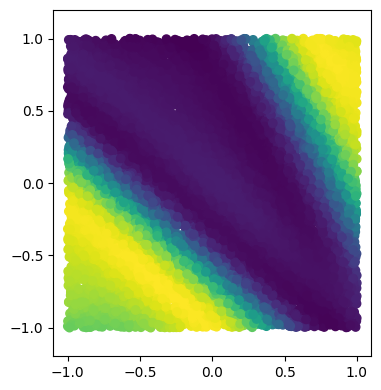

In [51]:
# z1 = torch.normal(0, 1, size=(1, z_dim,))
z1 = torch.rand(1, z_dim) * 2 - 1


x = torch.concat(
    (
        eval_s.unsqueeze(0).repeat(1, 1, 1),
        z1.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
    ),
    dim=-1
)

x = x.to(device)
r = model(x).squeeze(-1)

plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
plt.axis("equal") 
plt.tight_layout()
plt.show()

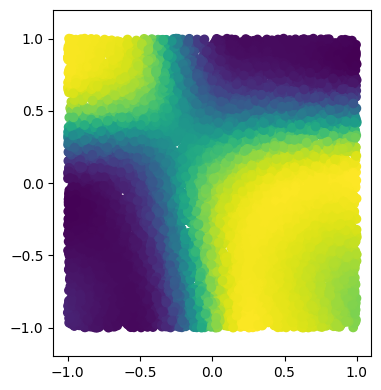

In [55]:
# z1 = torch.normal(0, 1, size=(1, z_dim,))
z2 = torch.rand(1, z_dim) * 2 - 1

x = torch.concat(
    (
        eval_s.unsqueeze(0).repeat(1, 1, 1) * 1,
        z2.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
    ),
    dim=-1
)

x = x.to(device)
r = model(x).squeeze(-1)

plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
plt.axis("equal") 
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'z2' is not defined

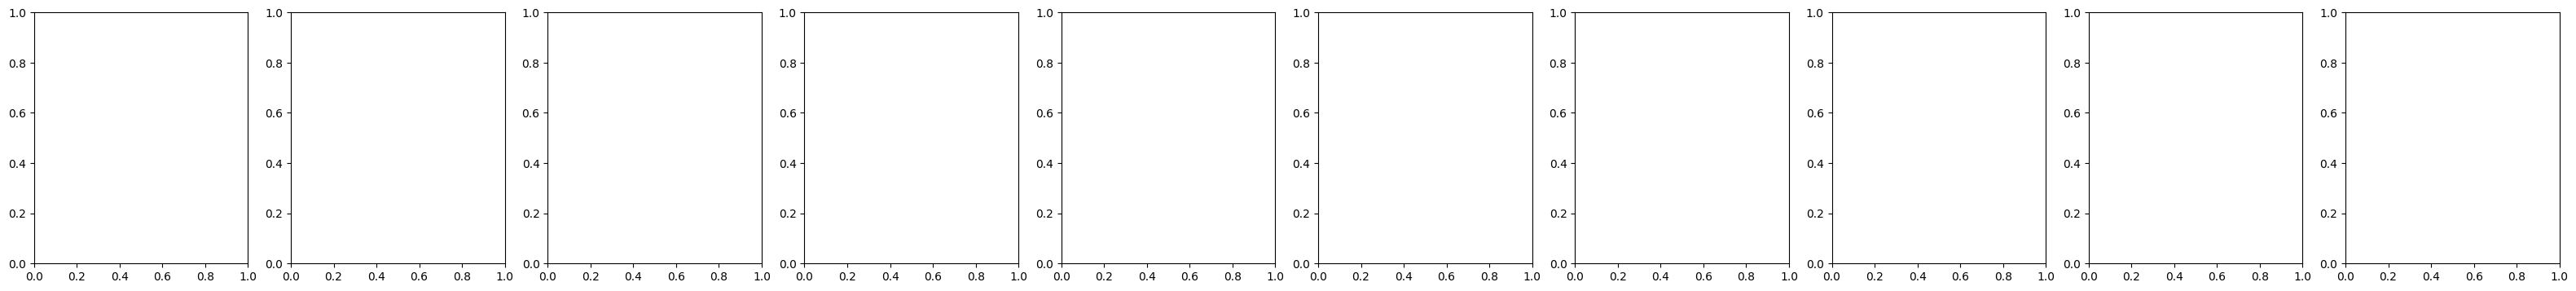

In [25]:
fig, axs = plt.subplots(1, 10, figsize=(4*10, 4))

for i, a in enumerate(tqdm(torch.linspace(0, 1, 10))):
    
    za = (1-a)*z1 + a*z2
    
    x = torch.concat(
        (
            eval_s.unsqueeze(0).repeat(1, 1, 1),
            za.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
        ),
        dim=-1
    )

    x = x.to(device)
    r = model(x).squeeze(-1)

    axs[i].scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
    # plt.show()
    

100%|██████████| 1000/1000 [00:01<00:00, 769.27it/s]


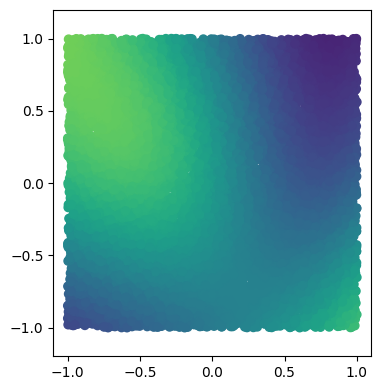

In [27]:
coverage = torch.zeros((1, 10000,), device=device)
for _ in tqdm(range(1000)):

    # z1 = torch.normal(0, 1, size=(1, z_dim,))
    z = torch.rand(1, z_dim) * 2 - 1


    x = torch.concat(
        (
            eval_s.unsqueeze(0).repeat(1, 1, 1) * 1,
            z.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
        ),
        dim=-1
    )

    with torch.no_grad():
        x = x.to(device)
        r = model(x).squeeze(-1)
        coverage = coverage + r
        # coverage = torch.max(coverage, r)
        # print(r)
    
coverage = coverage / 1000

plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=coverage.detach().cpu(), vmin=-1, vmax=1)
plt.axis("equal") 
plt.tight_layout()
plt.show()

In [58]:
coverage.min(), coverage.max()

(tensor(-0.7220, device='cuda:0'), tensor(0.7403, device='cuda:0'))

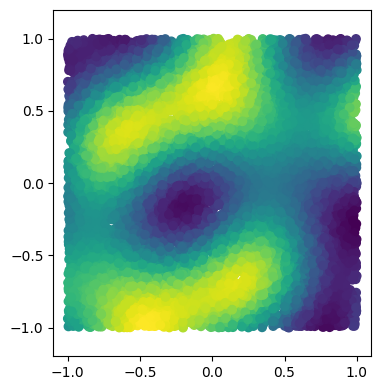

In [72]:
plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
plt.axis("equal") 
plt.tight_layout()
plt.show()

---

In [671]:
coverage

tensor(1220.8719, device='cuda:0')